In [3]:
!pip install python-mecab-ko

     |████████████████████████████████| 578 kB 7.1 MB/s            
     |████████████████████████████████| 34.5 MB 57.1 MB/s            


In [1]:
from mecab import MeCab
import os

### 토크나이저 MeCab사용

In [3]:
mecab = MeCab()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = mecab.pos(line)
        res = []
        for w in words: # 품사가 명사인 경우만 
            if w[1] in ["NNG", "NNP", "NNB"]: # 일반명사, 고유명사, 의존명사 추출
                res.append(w[0])
        tokenized.append(res)

### Word2Vec  CBoW 방식 사용

In [4]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  

- 학습된 워드임베딩 단어 유사도 추출

In [5]:
model.wv.most_similar(positive=['영화'])[:3]

[('작품', 0.9007689356803894),
 ('다큐멘터리', 0.8766986131668091),
 ('드라마', 0.8686078786849976)]

In [6]:
model.wv.most_similar(positive=['남자'])[:3]

[('여자', 0.9496199488639832),
 ('외간', 0.8048948645591736),
 ('종두', 0.7723110318183899)]

In [7]:
model.wv.most_similar(positive=['생물'])[:3]

[('야생', 0.9694092869758606),
 ('탐험', 0.9613066911697388),
 ('곤충', 0.960272490978241)]

- 그럭저럭 학습이 잘 된 모습이다.

In [8]:
genre_type = ['synopsis_art.txt', 'synopsis_gen.txt']
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

장르 type(예술영화, 일반영화)을 target으로 하고 장르를 atribute로 편향성을 계산해본다.

In [10]:
def read_token(file_name):
    mecab = MeCab()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread:
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline()
            if not line: break
            tokenlist = mecab.pos(line)
            for word in tokenlist:
                if word[1] in ["NNG", "NNP", "NNB"]: # 일반,고유,의존명사만 저장
                    result.append((word[0]))
    return ' '.join(result)

In [11]:
art = read_token(genre_type[0]) # 예술영화
gen = read_token(genre_type[1]) # 일반영화

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


- 장르를 대표하는 단어를 추출하기 위해서 TF-IDF를 사용

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])
print(X.shape)

(2, 43371)


In [13]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

In [14]:
print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
자신, 시작, 사랑, 사람, 친구, 영화, 남자, 여자, 가족, 

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


이야기, 마을, 마음, 사건, 세상, 아버지, 아이, 엄마, 시간, 세계, 아들, 소녀, 아내, 사이, 영화제, 감독, 서로, 남편, 비밀, 여행, 인생, 학교, 발견, 순간, 사실, 음악, 생활, 아빠, 마지막, 행복, 기억, 모습, 죽음, 소년, 이상, 도시, 단편, 사고, 결혼, 한편, 때문, 위기, 생각, 관계, 성공, 전쟁, 일상, 경찰, 최고, 과거, 인간, 현실, 미국, 상황, 결심, 운명, 여인, 하루, 이름, 이후, 준비, 위험, 동안, 감정, 충격, 살인, 부모, 한국, 존재, 연인, 어머니, 희망, 특별, 결국, 청년, 국제, 시절, 동생, 작가, 작품, 여성, 상처, 모두, 사회, 목숨, 할머니, 진실, 매력, 계획, 일본, 프랑스, 

일반영화를 대표하는 단어들:
자신, 영화제, 사람, 시작, 영화, 친구, 국제, 남자, 사랑, 이야기, 여자, 서울, 사건, 남편, 가족, 아이, 아버지, 세계, 시간, 단편, 마을, 엄마, 마음, 아들, 모습, 관계, 감독, 생각, 작품, 사이, 세상, 발견, 아내, 여성, 소녀, 사실, 애니메이션, 때문, 이상, 인간, 생활, 죽음, 결혼, 비밀, 상황, 학교, 기억, 도시, 여행, 소년, 한편, 순간, 서로, 과거, 경찰, 동안, 미국, 마지막, 현실, 전쟁, 존재, 일상, 주인공, 사회, 사고, 어머니, 연출, 인생, 섹스, 다큐멘터리, 부문, 한국, 살인, 위험, 행복, 최고, 의도, 위기, 동생, 조직, 부부, 회사, 계획, 이후, 일본, 시절, 성공, 아빠, 결국, 문제, 부산, 하루, 음악, 부모, 운명, 감정, 경쟁, 사진, 결심, 할머니, 

- 100중에서 중복을 제거한 15개의 단어만 추출

-> 대표성이 있는 단어만 추출하기 위해서 중복을 제거

In [15]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [16]:
# 예술영화를 대표하는 단어 15개
target_art

['여인',
 '이름',
 '준비',
 '충격',
 '연인',
 '희망',
 '특별',
 '청년',
 '작가',
 '상처',
 '모두',
 '목숨',
 '진실',
 '매력',
 '프랑스']

In [17]:
# 일반영화를 대표하는 단어 15개
target_gen

['서울',
 '애니메이션',
 '주인공',
 '연출',
 '섹스',
 '다큐멘터리',
 '부문',
 '의도',
 '조직',
 '부부',
 '회사',
 '문제',
 '부산',
 '경쟁',
 '사진']

- attributes 단어 추출

In [58]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))
    
    
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)
m = [X[i].tocoo() for i in range(X.shape[0])]
w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]


for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
    
    
attributes = []
for i in range(len(w)):
    attr = []
    j = 0
    
    attr_num = 200
    if i == 6: # 드라마의 경우 중복 제거를 하면 단어가 3개밖에 남지 않아서
        attr_num = 400 # 다른 단어들은 200개씩 추출하고 드라마는 400개 추출
        
    while (len(attr) < attr_num): # 총 100개의 단어를 추출하고 나중에 중복 제거
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
        j += 1
    attributes.append(attr)

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [70]:
# 각 attribute끼리의 중복 단어 제거
new_attributes = []
for i in range(len(attributes)):
    # i번째 리스트
    temp = attributes[i]
    
    # i번째 리스트를 제외한 나머지 리스트들만 합쳐서 others로 만듬
    others = set().union(*[attributes[j] for j in range(len(attributes)) if j != i])
    
    unique_words = [word for word in temp if word not in others] # attribute의 순서를 유지하면서 중복 아닌 단어 추출
    new_attributes.append(unique_words[:15])

In [71]:
for i in range(len(new_attributes)):
    print(i, genre_name[i], len(new_attributes[i]))

0 SF 15
1 가족 15
2 공연 15
3 공포(호러) 15
4 기타 15
5 다큐멘터리 15
6 드라마 15
7 멜로로맨스 15
8 뮤지컬 15
9 미스터리 15
10 범죄 15
11 사극 15
12 서부극(웨스턴) 15
13 성인물(에로) 15
14 스릴러 15
15 애니메이션 15
16 액션 15
17 어드벤처 15
18 전쟁 15
19 코미디 15
20 판타지 15


In [72]:
for i in range(len(new_attributes)):
    print(f'[{genre_name[i]}]\n중복제거 : ', ' '.join(new_attributes[i]))
    print('중복포함 : ', ' '.join(attributes[i][:15]))

[SF]
중복제거 :  외계 시스템 스타크 리플리 멸망 수퍼맨 외계인 물체 분파 진화 마토바 상어 히노 섹터 수트
중복포함 :  자신 지구 시작 사람 인류 인간 세계 우주 미래 로봇 박사 친구 거대 외계 우주선
[가족]
중복제거 :  낙타 씨제이 동구 소누 펠리칸 미아 크리쉬나 케이시 요세핀 최호 제난 마갈 베일리 네이슨 혜지
중복포함 :  엄마 아빠 영화제 가족 자신 친구 아버지 시작 아들 사랑 마을 국제 아이 낙타 할머니
[공연]
중복제거 :  비올레타 실황 백작 레오노라 알프레도 오텔로 리골레토 베르디 콘서트 만리 타미 비바 파미 아라벨라 기사장
중복포함 :  사랑 오페라 비올레타 실황 스카르피 토스카 백작 자신 카바 레오노라 공연 알프레도 오텔로 리골레토 베르디
[공포(호러)]
중복제거 :  악령 귀신 기운 로즈 레드 신부 심령 캠핑 호러 실체 분홍 관련 지하 두려움 환영
중복포함 :  친구 시작 사람 자신 공포 사건 발견 죽음 남자 이상 마을 영화 여자 가족 악령
[기타]
중복제거 :  메트로 광주 프라이드 디지털 공사 장소 교통 언어 독도 시각 재연 사물 에리코 화면 소통
중복포함 :  영화제 국제 서울 단편 영화 자신 사람 이야기 남자 여자 친구 사랑 시작 페스티벌 미디어
[다큐멘터리]
중복제거 :  투쟁 건축 문화 인터뷰 페스 당시 목소리 울주 국가 건축사 세대 공동체 노동 산업 혁명
중복포함 :  영화제 영화 다큐 다큐멘터리 국제 사람 이야기 감독 자신 서울 세계 여성 시작 가족 한국
[드라마]
중복제거 :  갈등 드라마 조금 대상 가난 포기 초청 성장 버스 장면 의지 청춘 예상 아픔 각자
중복포함 :  자신 영화제 사랑 영화 사람 시작 남자 친구 국제 여자 이야기 엄마 단편 가족 아버지
[멜로로맨스]
중복제거 :  형부 세희 미연 펜션 옆집 수진 하숙집 주희 요코 은지 하룻밤 처제 정식 준석 호감
중복포함 :  사랑 남자 자신 친구 여자 시작 남편 사람 섹스 마음 결혼 아내 관계 부부 영화
[뮤지컬]
중복제거 :  뮤지컬 지모도 에스메랄다 프

In [73]:
import numpy as np
import pandas as pd
from numpy.linalg import norm

def weat_score(X, Y, A, B): # weat score 구하는 함수
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

def cos_sim(i, j): # 코사인 유사도 구하는 함수
    return np.dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B): # weat score에서 사용되는 s값 구하는 함수
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

In [74]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
X = np.array([model.wv[word] for word in target_art]) # X는 예술영화로 고정
Y = np.array([model.wv[word] for word in target_gen]) # Y는 일반영화로 고정

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in new_attributes[i]]) # attribute중에 하나를 A로 설정
        B = np.array([model.wv[word] for word in new_attributes[j]]) # attribute중에 하나를 B로 설정
        matrix[i][j] = weat_score(X, Y, A, B)

In [75]:
result_df = pd.DataFrame()
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        result_df.loc[len(result_df), ['targetX', 'targetY', 'atrA', 'atrB','weat']] = ['art', 'gen', genre_name[i], genre_name[j], matrix[i][j]]

In [76]:
result_df.sort_values('weat').head(10) # weat 하위 10개

,targetX,targetY,atrA,atrB,weat
75,art,gen,기타,드라마,-1.021430
84,art,gen,기타,애니메이션,-0.967579
170,art,gen,사극,어드벤처,-0.893670
143,art,gen,뮤지컬,판타지,-0.874663
140,art,gen,뮤지컬,어드벤처,-0.845031
173,art,gen,사극,판타지,-0.839129
138,art,gen,뮤지컬,애니메이션,-0.832286
89,art,gen,기타,판타지,-0.825498
2,art,gen,SF,공포(호러),-0.795333
86,art,gen,기타,어드벤처,-0.790938


In [77]:
result_df.sort_values('weat',ascending=False).head(10) # weat 상위 10개

,targetX,targetY,atrA,atrB,weat
124,art,gen,멜로로맨스,성인물(에로),1.260428
44,art,gen,공연,뮤지컬,1.032909
26,art,gen,가족,뮤지컬,0.884843
57,art,gen,공포(호러),기타,0.876956
64,art,gen,공포(호러),사극,0.843518
58,art,gen,공포(호러),다큐멘터리,0.812603
61,art,gen,공포(호러),뮤지컬,0.771509
22,art,gen,가족,기타,0.760358
145,art,gen,미스터리,사극,0.707905
29,art,gen,가족,사극,0.706637


<AxesSubplot:>

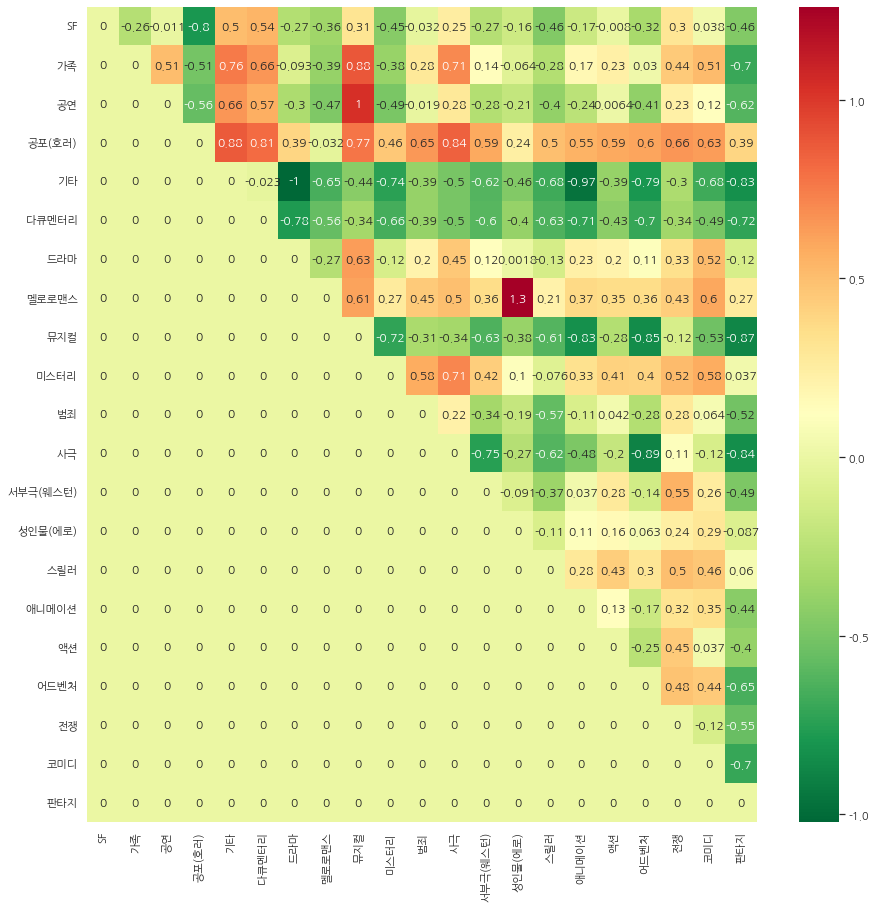

In [78]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(15, 15))
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

- 중복 제거 안한 WEAT 스코어

In [85]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
X = np.array([model.wv[word] for word in target_art]) # X는 예술영화로 고정
Y = np.array([model.wv[word] for word in target_gen]) # Y는 일반영화로 고정

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i][:15]]) # attribute중에 하나를 A로 설정
        B = np.array([model.wv[word] for word in attributes[j][:15]]) # attribute중에 하나를 B로 설정
        matrix[i][j] = weat_score(X, Y, A, B)

In [86]:
result_df = pd.DataFrame()
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        result_df.loc[len(result_df), ['targetX', 'targetY', 'atrA', 'atrB','weat']] = ['art', 'gen', genre_name[i], genre_name[j], matrix[i][j]]

In [87]:
result_df.sort_values('weat').head(10) # 중복 제거 안 한 weat 하위 10개

,targetX,targetY,atrA,atrB,weat
101,art,gen,다큐멘터리,어드벤처,-0.987847
196,art,gen,애니메이션,어드벤처,-0.952001
86,art,gen,기타,어드벤처,-0.946886
80,art,gen,기타,사극,-0.941797
75,art,gen,기타,드라마,-0.937693
140,art,gen,뮤지컬,어드벤처,-0.926532
134,art,gen,뮤지컬,사극,-0.915417
104,art,gen,다큐멘터리,판타지,-0.914224
88,art,gen,기타,코미디,-0.901236
95,art,gen,다큐멘터리,사극,-0.886112


In [88]:
result_df.sort_values('weat',ascending=False).head(10) # 중복 제거 안 한  weat 상위 10개

,targetX,targetY,atrA,atrB,weat
40,art,gen,공연,기타,0.967602
44,art,gen,공연,뮤지컬,0.965518
168,art,gen,사극,애니메이션,0.957691
206,art,gen,어드벤처,판타지,0.929830
51,art,gen,공연,애니메이션,0.916065
41,art,gen,공연,다큐멘터리,0.830896
33,art,gen,가족,애니메이션,0.814622
113,art,gen,드라마,애니메이션,0.813665
106,art,gen,드라마,뮤지컬,0.803663
58,art,gen,공포(호러),다큐멘터리,0.796981


<AxesSubplot:>

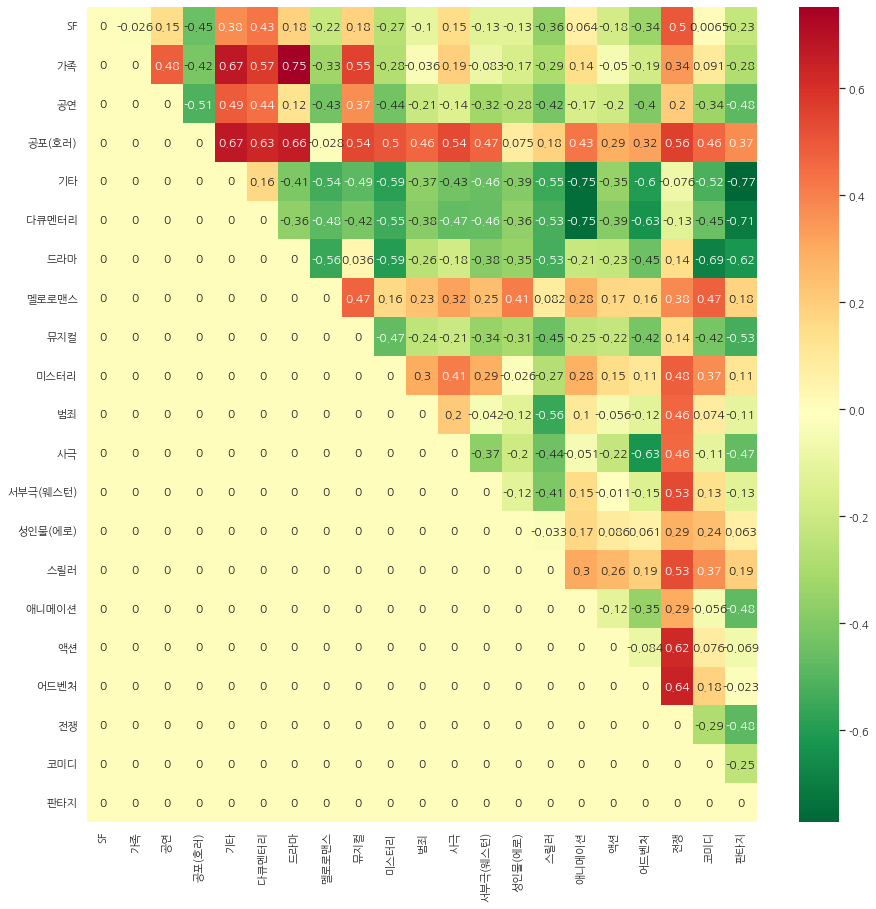

In [83]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(15, 15))
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

### 회고

1. Target, Attributes에 대표성 있는 단어를 선택하는게 중요하지만 어려웠다.
  - TF-IDF로 단어를 추출하고 중복 제거를 하면 대부분의 단어가 사라지게 된다
  
- < 자동제거방식 >
  - 중복을 제거


- < 수동제거방식 >
  - 대표성이 없는 단어들만 제거
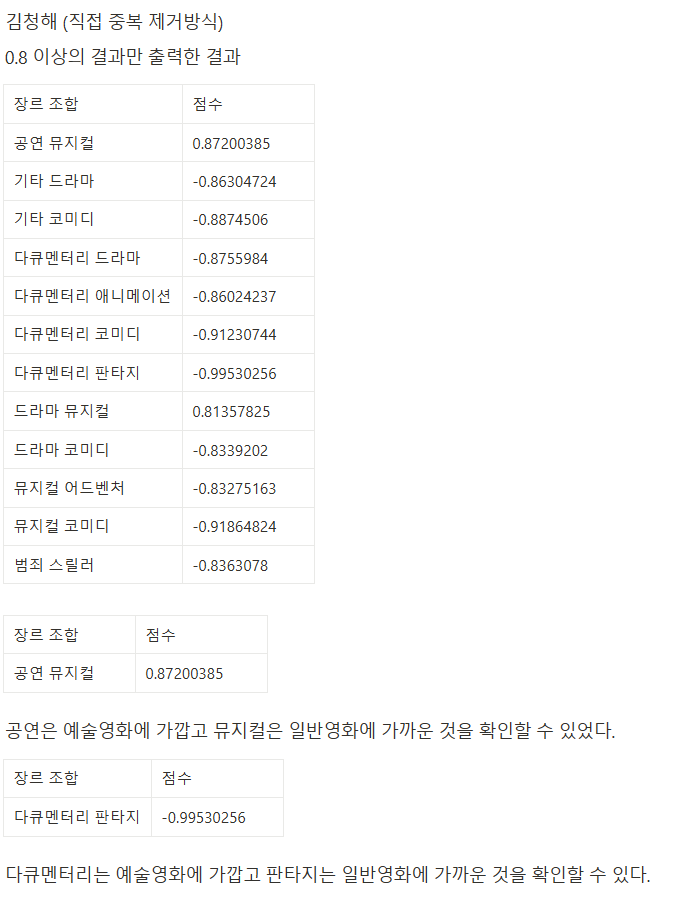


